### *Step 1: Importing necessary libraries*

In [1]:
import re
import pandas as pd

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

from pandas import DataFrame 
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from sklearn.metrics import mean_squared_error

<Figure size 640x480 with 0 Axes>

### *Step 2: Reading the Dataset*

In [2]:
df = pd.read_json('./Data/Luxury_Beauty.json', lines=True) #with pandas
df.head() #displaying top 5 rows

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,2,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,NaN,NaN
1,5,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,NaN,NaN
2,5,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
3,5,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
4,5,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,{'Size:': ' 3.5 oz.'},NaN


In [3]:
#checking the shape
df.shape

(574628, 12)

### *Step 3: Dataset pre-processing*
> Performing **product** based colloborative filtering

In [4]:
#grouping by on product id (which is asin) on bases of count and mean
grp_count = df.groupby("asin", as_index=False).count()
#grp_mean = df.groupby("asin", as_index=False).mean()

#joining the dataframes
df_joined = pd.merge(df, grp_count, how='right', on=['asin'])
df_joined.head()

,overall_x,vote_x,verified_x,reviewTime_x,reviewerID_x,asin,reviewerName_x,reviewText_x,summary_x,unixReviewTime_x,...,vote_y,verified_y,reviewTime_y,reviewerID_y,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y,style_y,image_y
0,2,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,...,40,582,582,582,582,581,582,582,567,3
1,5,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,...,40,582,582,582,582,581,582,582,567,3
2,5,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,...,40,582,582,582,582,581,582,582,567,3
3,5,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,...,40,582,582,582,582,581,582,582,567,3
4,5,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,...,40,582,582,582,582,581,582,582,567,3


In [5]:
#renaming columns
df_joined["num_reviewers"] = df_joined["reviewerID_y"]
df_joined["total_score"] = df_joined["overall_x"]
df_joined["review_summary"] = df_joined["summary_x"]

#making a new df containing just three columns
df_final = df_joined[['asin','review_summary','total_score',"num_reviewers"]]

<AxesSubplot:>

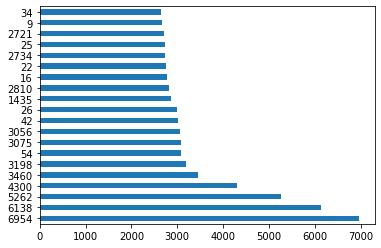

In [6]:
df_joined["num_reviewers"].value_counts()[:20].plot(kind='barh')

In [7]:
#selecting reviews which were reviewed by more than 80 users
df_joined = df_joined.sort_values(by='num_reviewers', ascending=False)
df_joined_above_50 = df_joined[df_joined.num_reviewers >= 80]
df_joined_above_50.head()

,overall_x,vote_x,verified_x,reviewTime_x,reviewerID_x,asin,reviewerName_x,reviewText_x,summary_x,unixReviewTime_x,...,reviewerID_y,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y,style_y,image_y,num_reviewers,total_score,review_summary
167975,5,NaN,True,"12 9, 2013",A5E2ZRLM50URD,B0013U0EYI,kris,Bought this for my grandmother and it is wond...,Amazing product!!!,1386547200,...,6954,6954,6944,6954,6954,0,146,6954,5,Amazing product!!!
162425,5,NaN,True,"09 9, 2017",A2FXWD1E8ACHVO,B0013U0EYI,Tadd R. Bennett,Surprisingly works..,Five Stars,1504915200,...,6954,6954,6944,6954,6954,0,146,6954,5,Five Stars
162414,4,NaN,True,"09 14, 2017",A136TNURBIFW8N,B0013U0EYI,bob long,It's as I expected,Four Stars,1505347200,...,6954,6954,6944,6954,6954,0,146,6954,4,Four Stars
162415,1,NaN,True,"09 14, 2017",A2V13SW5WOAWSR,B0013U0EYI,jdg,It doesn't work. It left no color and hair fe...,Waste of time and money.,1505347200,...,6954,6954,6944,6954,6954,0,146,6954,1,Waste of time and money.
162416,5,NaN,True,"09 14, 2017",A1AMUPZWZ0D3XD,B0013U0EYI,Katosel,"Exactly what I was looking for, a thickening h...","Exactly what I was looking for, a thickening h...",1505347200,...,6954,6954,6944,6954,6954,0,146,6954,5,"Exactly what I was looking for, a thickening h..."


<AxesSubplot:>

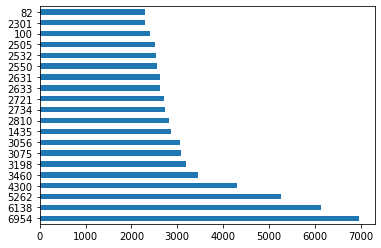

In [8]:
df_joined_above_50["num_reviewers"].value_counts()[:20].plot(kind='barh')

In [9]:
#making final product reviews dataset
df_product = df.groupby("asin", as_index=False).mean()
df_product_review = df_joined_above_50.groupby("asin")["review_summary"].apply(list)
df_product_review = pd.DataFrame(df_product_review)
df_product_review.to_csv("appliances_product_summary.csv")

In [10]:
df_product_review.head()

,review_summary
asin,
B00004U9V2,"[Best hand cream ever., dispensers don't work,..."
B00005NDTD,"[Five Stars, Five Stars, This is one of my fav..."
B00005V50B,[Works like I wanted it to without taking off ...
B000066SYB,"[Amazing mint scent and feel, My favorite loti..."
B000068DWY,"[Five Stars, Love it , Five Stars, Five Stars,..."


In [11]:
#merging
df_product_review = pd.read_csv("appliances_product_summary.csv")
df_product_review = pd.merge(df_product_review, df_product, on="asin", how='inner')

In [12]:
df_product_review = df_product_review[['asin','review_summary','overall']]
df_product_review.head()

,asin,review_summary,overall
0,B00004U9V2,"['Best hand cream ever.', ""dispensers don't wo...",4.623711
1,B00005NDTD,"['Five Stars', 'Five Stars', 'This is one of m...",4.862500
2,B00005V50B,['Works like I wanted it to without taking off...,4.177419
3,B000066SYB,"['Amazing mint scent and feel', 'My favorite l...",4.493421
4,B000068DWY,"['Five Stars', 'Love it ', 'Five Stars', 'Five...",4.373596


In [13]:
df_ranges = pd.crosstab(df_product_review['asin'], pd.cut(df_product_review['overall'], [2, 2.5, 3.0, 3.5, 4.0, 4.5, 5]))
df_ranges.head()

overall,"(2.5, 3.0]","(3.0, 3.5]","(3.5, 4.0]","(4.0, 4.5]","(4.5, 5.0]"
asin,,,,,
B00004U9V2,0,0,0,0,1
B00005NDTD,0,0,0,0,1
B00005V50B,0,0,0,1,0
B000066SYB,0,0,0,1,0
B000068DWY,0,0,0,1,0


<AxesSubplot:xlabel='overall'>

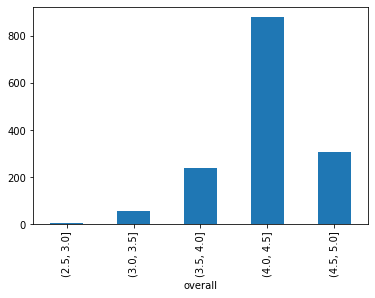

In [14]:
df_ranges.sum().plot.bar()

<AxesSubplot:>

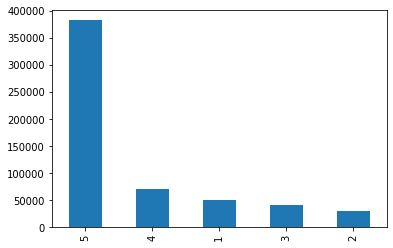

In [15]:
df['overall'].value_counts().plot(kind='bar')

### *Step 4: Text Cleaning*

In [16]:
#tokenizing text
reg = re.compile('[^a-z]+')
def cleanText(text):
    text = text.lower()
    text = reg.sub(' ', text).strip()
    return text

In [17]:
#drop duplicate rows
df_product_review["cleaned_review"] = df_product_review["review_summary"].apply(cleanText)
df_product_review = df_product_review.drop_duplicates(['overall'], keep='last')
df_product_review = df_product_review.reset_index()

In [18]:
#count vectorization
reviews = df_product_review["cleaned_review"] 
countVector = CountVectorizer(max_features = 200, stop_words='english') 
transformed_reviews = countVector.fit_transform(reviews) 

df_reviews = DataFrame(transformed_reviews.A, columns=countVector.get_feature_names())
df_reviews = df_reviews.astype(int)

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
#save 
df_reviews.to_csv("appliances_reviews.csv")

### *Step 5: Train Test Split*

In [20]:
X = np.array(df_reviews)
train_test_ratio = 0.9
size = int(np.floor(train_test_ratio * len(X)))
X_train = X[:size]
X_test = X[size:]

In [21]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X_train)
distances, indices = neighbor.kneighbors(X_train)

### Step 6: *Finding related products*

In [22]:
#find most related products
for i in range(len(X_test)):
    product_test = neighbor.kneighbors([X_test[i]])
    related_products = product_test[1]

    related_product_1 = [item[0] for item in related_products]
    related_product_1 = str(related_product_1).strip('[]')
    related_product_1 = int(related_product_1)
    
    related_product_2 = [item[1] for item in related_products]
    related_product_2 = str(related_product_2).strip('[]')
    related_product_2 = int(related_product_2)
    
    print ("Based on product reviews, for ", df_product_review["asin"][len(X_train) + i] ," average rating is ",df_product_review["overall"][len(X_train) + i])
    print ("The first similar product is ", df_product_review["asin"][related_product_1] ," average rating is ",df_product_review["overall"][related_product_1])
    print ("The second similar product is ", df_product_review["asin"][related_product_2] ," average rating is ",df_product_review["overall"][related_product_2])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B00SVLSES0  average rating is  4.424107142857143
The first similar product is  B007WKCJRS  average rating is  4.069868995633188
The second similar product is  B00DHOROQ4  average rating is  4.15979381443299
-----------------------------------------------------------
Based on product reviews, for  B00SZF7ZW8  average rating is  3.409090909090909
The first similar product is  B0007ZG2DW  average rating is  4.091954022988506
The second similar product is  B00G993GUC  average rating is  3.8536585365853657
-----------------------------------------------------------
Based on product reviews, for  B00T07GQ3E  average rating is  4.122641509433962
The first similar product is  B002D48QRU  average rating is  4.201612903225806
The second similar product is  B001K9X9W6  average rating is  4.704545454545454
-----------------------------------------------------------
Based on product reviews, for  B00T5DZ4C2  average rating is  3.0934065934065935
The first similar prod

Based on product reviews, for  B01DQG3DFI  average rating is  3.914754098360656
The first similar product is  B000BGRC18  average rating is  3.9047619047619047
The second similar product is  B003627RBY  average rating is  4.277777777777778
-----------------------------------------------------------
Based on product reviews, for  B01DWRRV4A  average rating is  4.4576271186440675
The first similar product is  B004MZSFN8  average rating is  4.5754716981132075
The second similar product is  B001LFCMF4  average rating is  4.663716814159292
-----------------------------------------------------------
Based on product reviews, for  B01E7UY7AC  average rating is  3.8125
The first similar product is  B000VEOY16  average rating is  4.440476190476191
The second similar product is  B00B46F9WI  average rating is  4.2560975609756095
-----------------------------------------------------------
Based on product reviews, for  B01E9I43RO  average rating is  4.312655086848635
The first similar product is  

In [23]:
y_train = df_product_review["overall"][:len(X_train)].apply(np.ceil)
y_test = df_product_review["overall"][len(X_train):len(X_train)+len(X_test)].apply(np.ceil)

### *Over Sampling*

<AxesSubplot:>

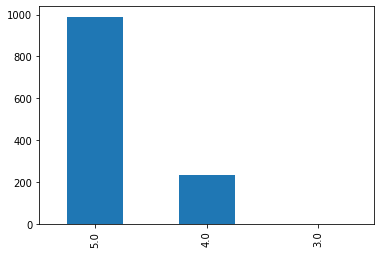

In [24]:
#before over sampling
y_train.value_counts().plot(kind='bar')

In [25]:
# over = SMOTE(k_neighbors=3)
# X_train, y_train = over.fit_resample(X_train, y_train)

In [26]:
# #after over sampling
# y_train.value_counts().plot(kind='bar')

### *Apply kNN*

In [27]:
clf = neighbors.KNeighborsClassifier(3, weights='distance')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.52      0.26      0.34        43
         5.0       0.73      0.91      0.81        91

    accuracy                           0.69       137
   macro avg       0.42      0.39      0.38       137
weighted avg       0.65      0.69      0.65       137



In [28]:
print (accuracy_score(y_test, pred))
print(mean_squared_error(y_test, pred))

0.6861313868613139
0.3357664233576642


In [29]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanText)

In [30]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

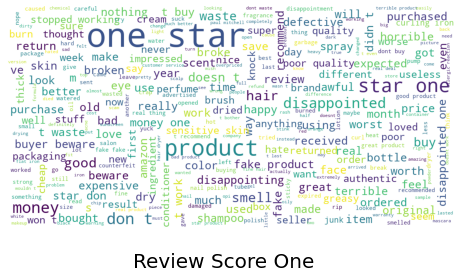

In [31]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

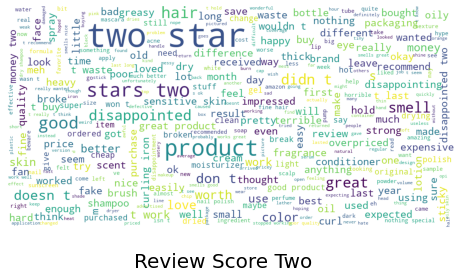

In [32]:
show_wordcloud(cluster1["summaryClean"][1], title = "Review Score Two")

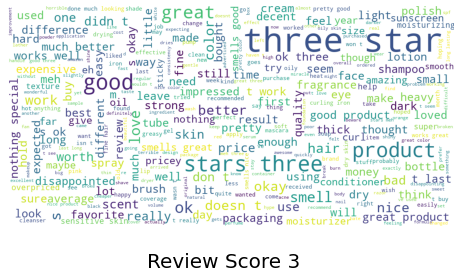

In [33]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score 3")

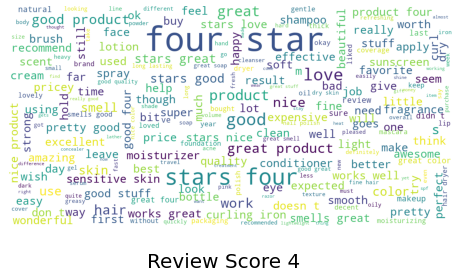

In [34]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score 4")

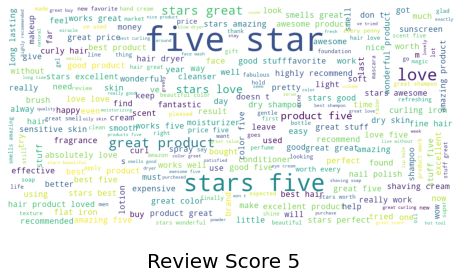

In [35]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score 5")

In [36]:
errors = []
K = range(1,10)
for k in K:
    model  = neighbors.KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    errors.append(mean_squared_error(y_test, pred))

Text(0, 0.5, 'Error Rate')

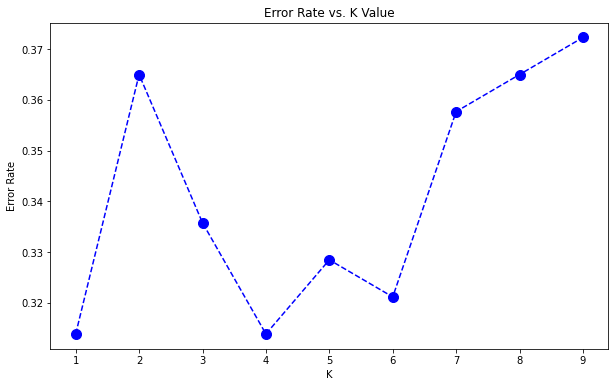

In [37]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10), errors, color='blue', linestyle='dashed', marker='o', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [38]:
clf = neighbors.KNeighborsClassifier(6, weights='distance')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))
print ("Accuracy: ",accuracy_score(y_test, pred))
print("MSE: ",mean_squared_error(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.56      0.21      0.31        43
         5.0       0.71      0.95      0.81        91

    accuracy                           0.69       137
   macro avg       0.42      0.38      0.37       137
weighted avg       0.65      0.69      0.63       137

Accuracy:  0.6934306569343066
MSE:  0.3284671532846715


/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
